# Interpretable Machine Learning with LIME - Tabular Data - Part 1 Exploratory Analysis

In this series of notebooks, we will fit a statistical (GLM) and a machine learning (RF) model to the Cleveland Heart Diseases data. Then, we will demonstrate using LIME (local interpretable model-agnostic explanations) to provide an easy for human to interpret explanation for the predictions. The goal here is to explore how LIME can provide a simple to interpret explanation for complex (normally human uninterpretable data) models.

Part 1 will be simplying cleaning and exploring the data. We will end with a decision tree model to get a preliminary model and ensure nothing went wrong in the process. 

### Load your packages
Per R convention (on not modifying user space), please install the packages below using the install.packages() command.

In [1]:
#Load libraries
library(tidyverse)
library(rpart)
library(rpart.plot)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



### Load, explore, and clean the data
1. We read in the csv file.
2. We check for incomplete cases. Because the percent is small (<2%), we elect to discard the data.
3. We use Hmisc to overview the data, and assign the correct classes to the columns.
4. We use jitterpolts in ggplot to get a preliminary feel for the data.

In [2]:
dat <- read.csv("Heart.csv", row.names = 1, stringsAsFactors=FALSE)

In [3]:
head(dat, 5)

Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<chr>,<chr>
63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No


In [4]:
dim(dat)
sum(!complete.cases(dat))/dim(dat)[1]

[1] 303  14

[1] 0.01980198

In [5]:
dat <- na.omit(dat)

In [6]:
Hmisc::describe(dat)

dat 

 14  Variables      297  Observations
--------------------------------------------------------------------------------
Age 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
     297        0       41    0.999    54.54    10.31       40       42 
     .25      .50      .75      .90      .95 
      48       56       61       66       68 

lowest : 29 34 35 37 38, highest: 70 71 74 76 77
--------------------------------------------------------------------------------
Sex 
       n  missing distinct     Info      Sum     Mean      Gmd 
     297        0        2    0.656      201   0.6768    0.439 

--------------------------------------------------------------------------------
ChestPain 
       n  missing distinct 
     297        0        4 
                                                              
Value      asymptomatic   nonanginal   nontypical      typical
Frequency           142           83           49           23
Proportion        0.478       

In [7]:
dat$Sex <- as.character(dat$Sex)
dat$Fbs <- as.character(dat$Fbs)
dat$RestECG <- as.character(dat$RestECG)
dat$ExAng <- as.character(dat$ExAng)
dat$Slope <- as.character(dat$Slope)
dat$Ca <- as.character(dat$Ca)
dat$AHD <- as.factor(dat$AHD)

### Predictions at a glance.
I find it useful to visually inspect the data (when possible). Ca, ChestPain,  ExAng, Oldpeak, Sex, Slope, and Thal appear to be useful variables for predicting AHD outcome at first glance. (Note that our model probably will not use all these variables

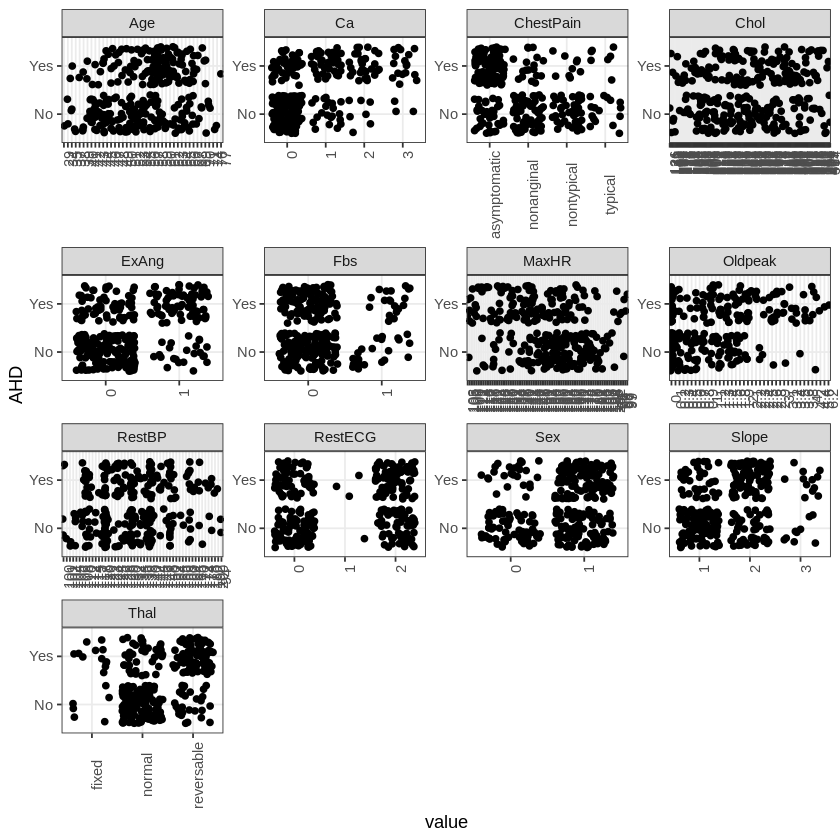

In [8]:
dat %>%
  gather(-AHD, key = "var", value = "value") %>% 
  ggplot(aes(x = value, y = AHD)) +
    geom_jitter() +
    facet_wrap(~ var, scales = "free") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90))

### Splitting data for model training and validation.
We use a 80/20 split through caret to split the data by outcome. We save the cleaned and split data as an RData object so we can use the exact split to compare different models. 

In [9]:
set.seed(1234)
trainIndex <- createDataPartition(dat$AHD, p = .8, 
                                  list = FALSE, 
                                  times = 1)

In [10]:
datTrain <- dat[ trainIndex,]
datTest  <- dat[-trainIndex,]
table(datTrain$AHD)
table(datTest$AHD)


 No Yes 
128 110 


 No Yes 
 32  27 

In [11]:
save(datTrain, datTest, file = "heart_data.RData")

### Decision Tree
We build a decision tree (probably the simpliest to understand model) to get a feel for the data using the rpart package. The interpretability of the tree model will be baseline for comparing LIME outputs. 

We use confusionMatrix to assess the accuracy and other model prediction statisics. We do it both on the training data and test data to get a sense of who much the model overfits the data.

For this model, the accuracy for the training data is 0.85. The accuracy for the test data is 0.86. Given the small number of test samples, these are indistinguishable from each other. This shows that the model is not over fitting because it performs as well on the test data as compared to the training data. 

In [12]:
set.seed(123456)
tree <- rpart(AHD ~ ., data = datTrain)
bestcp <- tree$cptable[which.min(tree$cptable[,"xerror"]),"CP"]
tree.pruned <- prune(tree, cp = bestcp)

In [13]:
confusionMatrix(predict(tree.pruned,newdata=datTrain,type="class"), datTrain$AHD)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  119  26
       Yes   9  84
                                          
               Accuracy : 0.8529          
                 95% CI : (0.8015, 0.8954)
    No Information Rate : 0.5378          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7009          
                                          
 Mcnemar's Test P-Value : 0.006841        
                                          
            Sensitivity : 0.9297          
            Specificity : 0.7636          
         Pos Pred Value : 0.8207          
         Neg Pred Value : 0.9032          
             Prevalence : 0.5378          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.6092          
      Balanced Accuracy : 0.8467          
                                          
       'Positive' Class : No              
                              

In [14]:
confusionMatrix(predict(tree.pruned,newdata=datTest,type="class"), datTest$AHD)

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  27   3
       Yes  5  24
                                          
               Accuracy : 0.8644          
                 95% CI : (0.7502, 0.9396)
    No Information Rate : 0.5424          
    P-Value [Acc > NIR] : 1.458e-07       
                                          
                  Kappa : 0.7284          
                                          
 Mcnemar's Test P-Value : 0.7237          
                                          
            Sensitivity : 0.8438          
            Specificity : 0.8889          
         Pos Pred Value : 0.9000          
         Neg Pred Value : 0.8276          
             Prevalence : 0.5424          
         Detection Rate : 0.4576          
   Detection Prevalence : 0.5085          
      Balanced Accuracy : 0.8663          
                                          
       'Positive' Class : No              
                                 

### Visualize the tree
We visualize the top tree. We see that only three variable are used in this decision tree. This decision is easy to interpret for humans, and decision trees are often great starting points for exploring and model building tabular data.

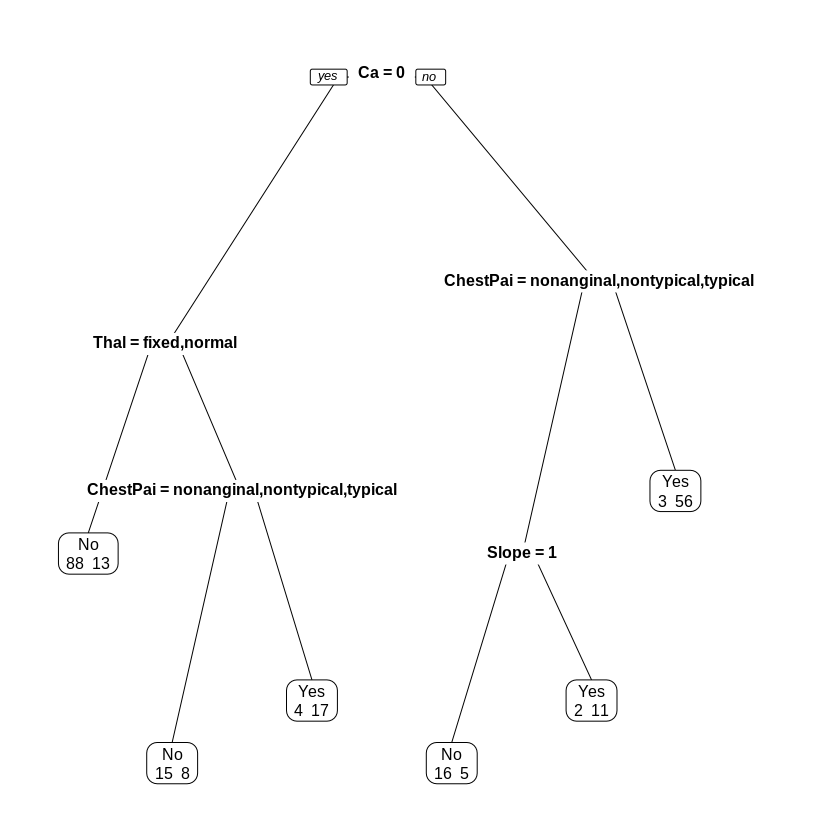

In [15]:
prp(tree.pruned, faclen = 0, cex = 0.8, extra = 1)